In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as st
import warnings 
warnings.filterwarnings('ignore') 

Dados históricos no qual as projeções vão se basear

In [2]:
faixas = pd.read_csv('distribuicoes.csv')
faixas = faixas.set_index(faixas['Unnamed: 0'])
del faixas['Unnamed: 0']
faixas.index.name = 'faixa'
faixas

,media,dp
faixa,,
0.1,0.332,0.181
0.2,0.411,0.187
0.3,0.417,0.192
0.4,0.432,0.198
0.5,0.476,0.214
0.6,0.495,0.213
0.7,0.537,0.214
0.8,0.607,0.211


In [3]:
jogos = pd.read_csv('jogos br 21.csv')

del jogos['Unnamed: 0']

jogos.head()

,awayScore,awayTeam,data,homeScore,homeTeam,rodada
0,2.0,1980.0,2021-05-29 20:55:03,2.0,49202.0,1.0
1,0.0,1968.0,2021-05-29 21:52:51,3.0,1955.0,1.0
2,0.0,1961.0,2021-05-29 22:56:36,0.0,1981.0,1.0
3,2.0,2020.0,2021-05-30 12:56:36,1.0,1977.0,1.0
4,0.0,1963.0,2021-05-30 17:56:23,1.0,5981.0,1.0


Tabela de clubes que possue o id, muito usado, de cada clube

In [4]:
df_clubes = pd.read_csv('clubes br21.csv').drop('Unnamed: 0', 1)

df_clubes.head()

,clubeId,clubeNome,clubeNomeCodigo,clubeShortName,clubeSlug
0,1977,Atlético Mineiro,ATM,Atlético MG,atletico-mineiro
1,1963,Palmeiras,PAL,Palmeiras,palmeiras
2,5981,Flamengo,FLA,Flamengo,flamengo
3,2020,Fortaleza,FOR,Fortaleza,fortaleza
4,1999,Red Bull Bragantino,BRA,RB Bragantino,red-bull-bragantino


Dicionário que vai guardar, já ordenado por data, o registro dos jogos de cada clube

In [5]:
clubes = dict()

for i in jogos.homeTeam.unique():
    clubes[str(int(i))] = jogos.loc[(jogos.homeTeam == i)|(jogos.awayTeam == i)].sort_values('data')

Script que vai iterar o dicionário anterior, ver quando o clube venceu, empatou ou perdeu e calcular seu aproveitamento médio dos ultimos 5 e 10 jogos

In [6]:
for clube_id in clubes.keys():
    temp = clubes[clube_id] # Temp é um DataFrame temporário para a manipulação dos dados
    
    temp.awayTeam = temp.awayTeam.apply(lambda x: str(int(x)))
    temp.homeTeam = temp.homeTeam.apply(lambda x: str(int(x)))

    temp.loc[(temp.homeTeam == clube_id) & (temp.homeScore > temp.awayScore), 'aproveitamento'] = 1
    temp.loc[(temp.homeTeam == clube_id) & (temp.homeScore == temp.awayScore), 'aproveitamento'] = 0.333
    temp.loc[(temp.homeTeam == clube_id) & (temp.homeScore < temp.awayScore), 'aproveitamento'] = 0

    temp.loc[(temp.awayTeam == clube_id) & (temp.homeScore > temp.awayScore), 'aproveitamento'] = 0
    temp.loc[(temp.awayTeam == clube_id) & (temp.homeScore < temp.awayScore), 'aproveitamento'] = 1
    temp.loc[(temp.awayTeam == clube_id) & (temp.homeScore == temp.awayScore), 'aproveitamento'] = 0.333

    temp['mm_5'] = temp.aproveitamento.rolling(5).mean()
    temp['mm_10'] = temp.aproveitamento.rolling(10).mean()
    temp['num_jogos'] = range(1, len(temp)+1)
    
    clubes[clube_id] = temp # Tratado, devolve-se o DataFrame para o lugar de origem

Funcao onde toda magia acontece. Ela é quem vai fazer toda as simulações. A princípio houve uma certa cautela com o fato dela usar listas e fazer as simulações uma a uma, mas ainda sim entrega por volta de 1000 simulações por segundo. No decorrer do código é discutido simulações usando o Numpy e o Pandas.

In [7]:
def monte_carlo(df): # Recebe o DataFrame anteriormente tratado
    
    global faixas
    
    num_jogos = df[-1:].num_jogos.values[0] # Quantos jogos jogou o clube?
    
    mm_5 = round(df[-1:].mm_5.values[0],1)   # Média movel dos últimos 5
    mm_10 = round(df[-1:].mm_10.values[0],1) # Média movel dos últimos 10
    mm_pre_5 = 2*mm_10 - mm_5                # Media movel dos 5 jogos que antecederam os últimos 5
    
    pontos = [round(df.aproveitamento.mean() * (3 * num_jogos))] # Começa uma lista que vai guardar essa "realidade" simulada
    # Índice é os eixos x dos gráficos, acredito que só um pra cada clube, mas fica essa solução como registro 
    indice = [num_jogos]                                        
    
    while num_jogos < 38: # Enquanto não exceder o número de rodadas do campeonato, continua simulando
        mm_10 = round((mm_pre_5 + mm_5)/2, 1)
        
        # Como discutido no código anterior, algumas faixas foram unidas, essa sequencia de IF cuida disso
        if mm_10 >0.8: 
            mm_10 = 0.8
        elif mm_10<0.1:
            mm_10 = 0.1     
        else:
            pass
        
        mm_pre_5 = mm_5 # Guarda a última media movel dos 5 jogos anteriores
        mm_5 = random.gauss(faixas.loc[mm_10, 'media'], faixas.loc[mm_10, 'dp']) # Simula uma nova média móvel
        
        # O aproveitamento não pode ser nem maior que 1 e nem menor que 0, a sequencia de IF cuida disso
        if mm_5 >1:
            mm_5 = 1
        elif mm_5<0:
            mm_5 = 0
        else:
            pass
        
        # Dá um 'passo' pro futuro
        num_jogos += 5
    
        # Excedeu-se o número de partidas do campenato? Faz uma interpolação com as médias anteriores
        if num_jogos > 38:
            
            dy = (pontos[-1] - pontos[-2])/5  # media de ponto nos últimos 5 jogos
            n_jogos = 38 - indice[-1] 
            
            pontos.append(round(pontos[-1] + n_jogos*dy,0))
            indice.append(38)
            
        else: 
            
            pontos.append(round(pontos[-1] + mm_5 * 15, 0))
            indice.append(num_jogos)
        
    return indice, pontos
    

Célula que faz as simulações com a função anterior e guarda as informações simuladas e reais 

In [8]:
pontuacao_real = dict()
pontuacao_simulada = dict()

for clube_id in clubes.keys():
    num_jogos = clubes[clube_id].num_jogos.values   # vetor o numero de jogos
    pontos = [round(clubes[clube_id].loc[:i, 'aproveitamento'].mean() * 3 * clubes[clube_id].loc[i, 'num_jogos'],0) for i in clubes[clube_id].index]
    
    pontuacao_real[clube_id] = np.array([num_jogos, pontos])
    
    simulacoes = []
    for i in range(1000):
        simulacoes.append([monte_carlo(clubes[clube_id])])
        
    pontuacao_simulada[clube_id] = np.array(simulacoes)

Script que guarda um vetor com todas as pontuacoes finais nas simulacoes

In [9]:
pontuacao_final = dict()

for clube_id in clubes.keys():
    
    pont_final = []
    for i in pontuacao_simulada[clube_id]:
        pont_final.append(i[0][1][-1])
        
    pontuacao_final[clube_id] = pont_final

# O Santos cai?

Célula destinada a calcular a frequencia por posições

In [10]:
clube_id = '1968'
cor_princ = '#000000'
cor_sec = '#696969'
nome = 'Santos'

posicoes_santos = pd.Series()


for j in range(1000):
    pont_santos = pontuacao_final[clube_id][j]  # pontuacao final do Santos na simulação j
    menores = 0
    
    for i in clubes.keys():
        if pontuacao_final[i][j] < pont_santos:  # O clube pontuou menos que o Santos?
            menores += 1
        else:
            pass
    
    p = str(20 - menores) # Posicao do Santos na Simulacao
    
    if p in posicoes_santos.index: # Faz a contagem de posições
        posicoes_santos[p] += 1
    else:
        posicoes_santos[p] = 1
        
posicoes_santos.index = posicoes_santos.index.astype('int')
posicoes_santos = posicoes_santos.sort_index()

posicoes_santos = posicoes_santos/posicoes_santos.sum()

# O santos cai?


Célula dos gráficos

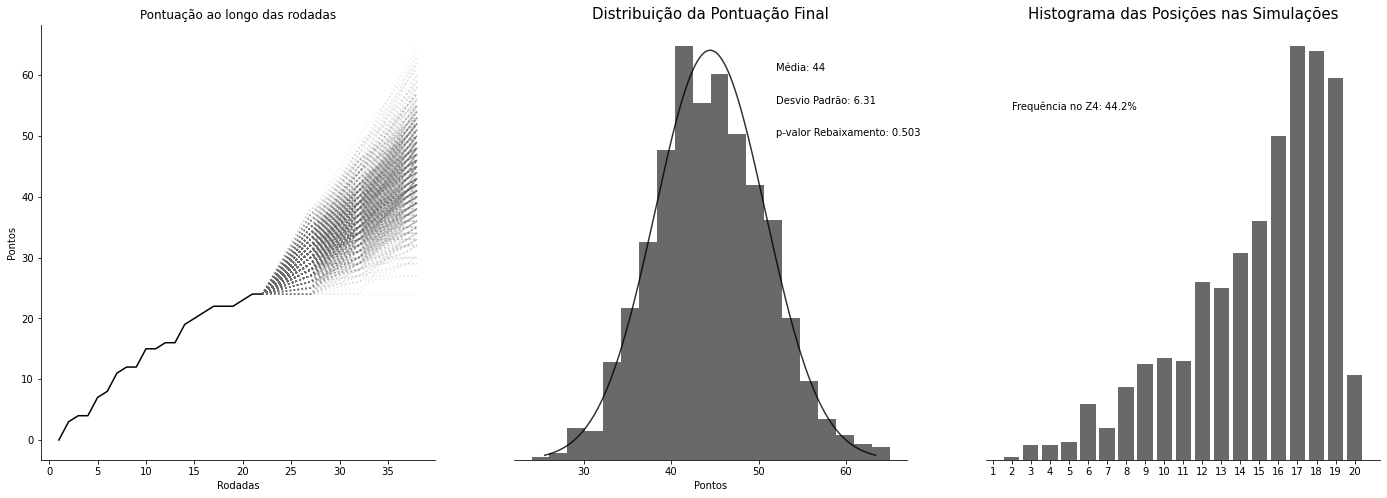

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# EVOLUCAO DA PONTUACAO NO TEMPO

# Pontos reais 
axs[0].plot(pontuacao_real[clube_id][0], pontuacao_real[clube_id][1], '-', color=cor_princ, label=nome)

# Pontos Projetados
for j in pontuacao_simulada[clube_id]:
        axs[0].plot(j[0][0], j[0][1], ':', color=cor_sec, alpha=0.1)
        
axs[0].set_title('Pontuação ao longo das rodadas')
axs[0].set_xlabel('Rodadas')
axs[0].set_ylabel('Pontos')
axs[0].spines['right'].set_visible(False) 
axs[0].spines['top'].set_visible(False)


# HISTOGRAMA DA PONTUACAO FINAL

axs[1].hist(pontuacao_final[clube_id], color=cor_sec,density=True, bins=20)
mu = np.array(pontuacao_final[clube_id]).mean()
sigma = np.array(pontuacao_final[clube_id]).std()

z_value = (44.5-mu)/sigma
p_value = st.norm.cdf(z_value)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
axs[1].plot(x, st.norm.pdf(x, mu, sigma), '-', color=cor_princ, alpha=0.8)

axs[1].text(52, 0.06, f'Média: {int(round(mu,0))}')
axs[1].text(52, 0.055, f'Desvio Padrão: {round(sigma,2)}')
axs[1].text(52, 0.05, f'p-valor Rebaixamento: {round(p_value,3)}')

axs[1].set_title('Distribuição da Pontuação Final', fontsize=15)
axs[1].get_yaxis().set_visible(False)
axs[1].spines['right'].set_visible(False)          
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].set_xlabel('Pontos')

# HISTOGRAMA DAS POSICOES

rebaixado = posicoes_santos.loc[posicoes_santos.index > 16].sum()


axs[2].bar(posicoes_santos.index, posicoes_santos, color = cor_sec)

axs[2].set_xticks(range(1,21)) 
axs[2].get_yaxis().set_visible(False)
axs[2].spines['right'].set_visible(False)          
axs[2].spines['top'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].text(2, 0.12, f'Frequência no Z4: {100*rebaixado}%')
axs[2].set_title('Histograma das Posições nas Simulações', fontsize=15)

plt.savefig('Santos o time do.png', dpi=400)

plt.show()

# Corrida pelo título

As seguintes células discutem as probabilidades de título entre Atlético, Flamengo e Palmeiras

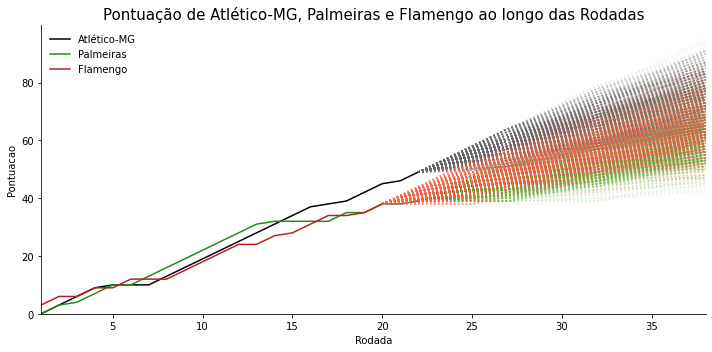

In [12]:
clube_id = ['1977', '1963', '5981']
cor_princ = ['#000000', '#228B22', '#B22222']
cor_sec = ['#696969', '#32CD32', '#FF6347']
nome = ['Atlético-MG', 'Palmeiras', 'Flamengo']

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Pontos reais
for i in range((len(clube_id))):
    axs.plot(pontuacao_real[clube_id[i]][0], pontuacao_real[clube_id[i]][1], '-', color=cor_princ[i], label=nome[i])

# Pontos Projetados
for i in range((len(clube_id))):
    for j in pontuacao_simulada[clube_id[i]]:
        axs.plot(j[0][0], j[0][1], ':', color=cor_sec[i], alpha=0.1)
    
    
# Configurando gráfico 

axs.set_title(f'Pontuação de Atlético-MG, Palmeiras e Flamengo ao longo das Rodadas', fontsize=15)
axs.set_xlabel('Rodada')
axs.set_ylabel('Pontuacao')
axs.set_xlim(xmin=1, xmax=38)
axs.set_ylim(ymin=0)

axs.spines['right'].set_visible(False)       
axs.spines['top'].set_visible(False)

axs.legend(frameon=False)
plt.tight_layout()

plt.savefig('Corrida ao título.png', dpi=500)
plt.show()

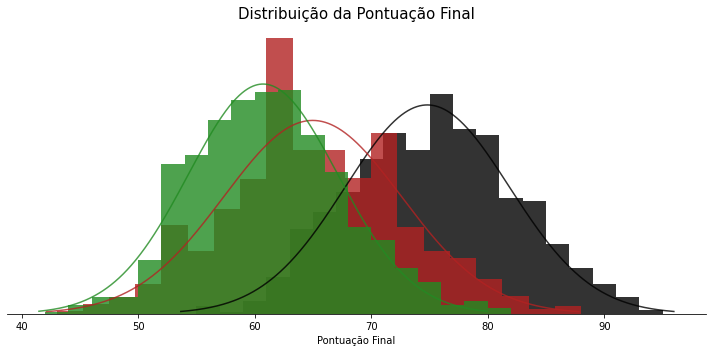

In [13]:
clube_id = ['1977', '5981','1963']
cor_princ = ['#000000', '#B22222','#228B22']

fig, axs = plt.subplots(1, 1, figsize=(10,5))


for i in range((len(clube_id))):
    axs.hist(pontuacao_final[clube_id[i]], color=cor_princ[i],density=True, alpha=0.8, bins=20)
    
    mu = np.array(pontuacao_final[clube_id[i]]).mean()
    sigma = np.array(pontuacao_final[clube_id[i]]).std()
    
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    axs.plot(x, st.norm.pdf(x, mu, sigma), '-', color=cor_princ[i], alpha=0.8, label=nome[i])
    
    
axs.set_title('Distribuição da Pontuação Final', fontsize=15)
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_xlabel('Pontuação Final')


plt.tight_layout()

plt.savefig('histo titulo.png', dpi=500)
plt.show()

# Probabilidade de título

Mais abaixo há outra forma na qual calcula-se a probabilidade, usando-se pandas. 
Ela foi pensada só depois, no entanto, mantem-se esta aqui como forma de registro, já que não tem problemas com a eficiência,
uma vez que usa Numpy

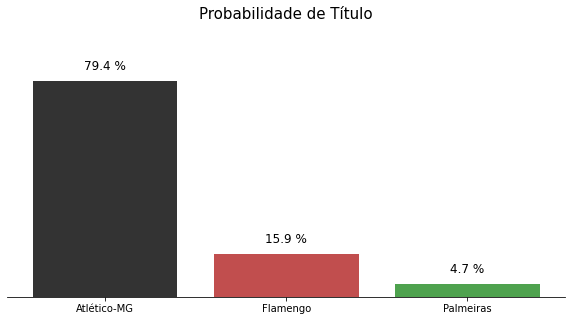

In [14]:
n = 1000000 # Numero de simulacoes

clube_id = ['1977', '5981','1963']
cor_princ = ['#000000', '#B22222','#228B22']
nome = ['Atlético-MG', 'Flamengo', 'Palmeiras',]

simul = []

fig, axs = plt.subplots(1, 1, figsize=(10,5))

for i in range((len(clube_id))):
    
    pts_fin = np.array(pontuacao_final[clube_id[i]])
    mu = pts_fin.mean()
    sigma = pts_fin.std()
    
    x = np.random.normal(mu, sigma, n) # Vetor aleatorio dos resultados possiveis
    simul.append(x)
    
    
# calcula o tamanho do vetor onde os clubes tiveram pontuacao melhor
gal_camp = 100* len(simul[0][(simul[0]>simul[1]) & (simul[0]>simul[2])])/n 
fla_camp = 100 * len(simul[1][(simul[1]>simul[0]) & (simul[1]>simul[2])])/n
pal_camp = 100 * len(simul[2][(simul[2]>simul[0]) & (simul[2]>simul[1])])/n

# Salva os resultados obtidos e formata-os para o gráfico
probabilidades = [gal_camp, fla_camp, pal_camp]
legenda = [f'{round(i,1)} %' for i in probabilidades]

# Plota os dados no grafico
plt.bar(nome, [gal_camp, fla_camp, pal_camp], color = cor_princ, alpha=0.8)

# Configura o gráfico
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim(ymax=100)

eixo = axs.patches
for eixo, legenda in zip(eixo, legenda):
    height = eixo.get_height()
    axs.text(eixo.get_x() + eixo.get_width() / 2, height + 3, legenda,
            ha='center', va='bottom', fontsize=12)

axs.set_title('Probabilidade de Título', fontsize=15)

plt.savefig('prob título.png', dpi=500)
plt.show()

# Clubes que correm risco de cair

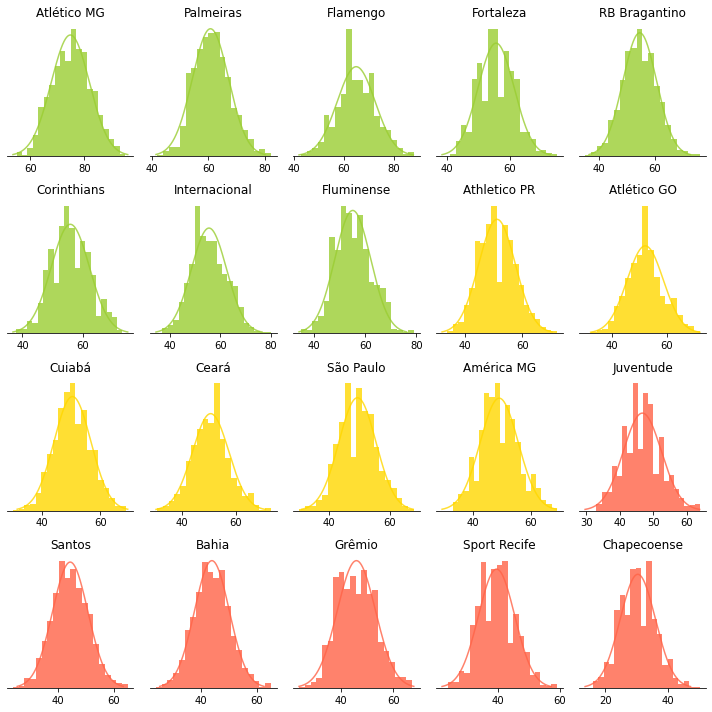

In [15]:
fig, axs = plt.subplots(4,5, figsize=(10,10), tight_layout=True)

j = 0

risco_rebai = [] #Lista pra salvar informações de quem tem chances de cair

for i in df_clubes.clubeId:
    
    nome = df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeShortName'].values[0] # Nome para o titulo
    
    # Configura o gráfico
    axs[j//5][j%5].set_title(nome)
    axs[j//5][j%5].get_yaxis().set_visible(False)
    axs[j//5][j%5].spines['right'].set_visible(False)          
    axs[j//5][j%5].spines['top'].set_visible(False)
    axs[j//5][j%5].spines['left'].set_visible(False)
    
    # Faz um 'teste de hipótese' pra ver o p-valor para a hipótese 'menos que 45 pontos'
    
    pts_fin = np.array(pontuacao_final[str(i)])
    mu = pts_fin.mean()
    sigma = pts_fin.std()
    
    z_value = (44.5-mu)/sigma
    p_value = st.norm.cdf(z_value)
    
    # sequencia de IF que controla a cor do histograma e salva quem pode cair
    if p_value > 0.3:
        
        risco_rebai.append([i, df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeNomeCodigo'].values[0], mu, sigma])
            
        axs[j//5][j%5].hist(pontuacao_final[str(i)], color='#FF6347',density=True, alpha=0.8, bins=20)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        axs[j//5][j%5].plot(x, st.norm.pdf(x, mu, sigma), '-', color='#FF6347', alpha=0.8)
        
    
    elif p_value > 0.1:
        
        risco_rebai.append([i, df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeNomeCodigo'].values[0], mu, sigma])
        
        axs[j//5][j%5].hist(pontuacao_final[str(i)], color='#FFD700',density=True, alpha=0.8, bins=20)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        axs[j//5][j%5].plot(x, st.norm.pdf(x, mu, sigma), '-', color='#FFD700', alpha=0.8)
    
    else:

        axs[j//5][j%5].hist(pontuacao_final[str(i)], color='#9ACD32',density=True, alpha=0.8, bins=20)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
        axs[j//5][j%5].plot(x, st.norm.pdf(x, mu, sigma), '-', color='#9ACD32', alpha=0.8)
        
    j += 1
    
plt.savefig('distribuicao de pontuacao esperada.png', dpi=500)
plt.show()

# Simulando rebaixamento

Essa é a outra solução citada, nela usa-se uma tabela onde cada linha representa um cenário

In [16]:
n = 10000 # Numero de simulacoes
df_rebaixado = pd.DataFrame()

for i in risco_rebai:# Itera a lista criada acima
    
    df_rebaixado[i[1]] = np.random.normal(i[2], i[3], n) # Vetor aleatório
    df_rebaixado[i[1]] = df_rebaixado[i[1]].apply(lambda x: round(x, 3)) # Arrendonda-se para não sobrecarregar a memória ram
    
    
# Laço para contar a frequencia em que o clube aparece no Z4     
feq_rebaixamento = pd.Series()
for i in range(n):
    
    cairam = df_rebaixado.loc[i].sort_values()[:4].index # 4 rebaixados do cenário i
    
    for i in cairam: # Itera cada um deles
        if i in feq_rebaixamento:
            feq_rebaixamento[i] += 1/n
        else:
            feq_rebaixamento[i] = 1/n
            
feq_rebaixamento # Resultado

CHA    0.9872
SRE    0.7385
SPA    0.1543
AGO    0.0892
BAH    0.4509
GRE    0.3512
SAN    0.4266
CEA    0.1265
ATP    0.1045
CUI    0.1227
JUV    0.2587
AMI    0.1897
dtype: float64

# Gráfico das probabildiades de rebaixamento

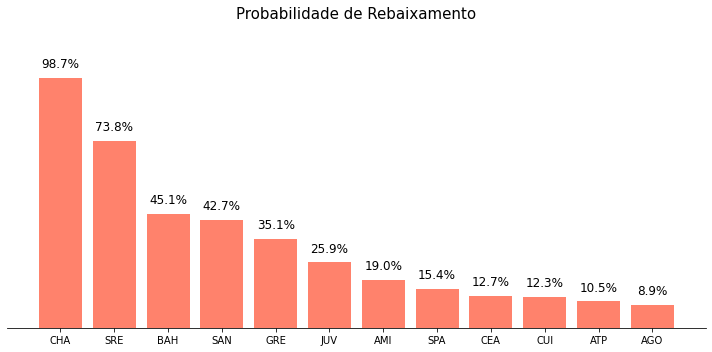

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

# Plota as informações
axs.bar(feq_rebaixamento.sort_values(ascending=False).index, 100*feq_rebaixamento.sort_values(ascending=False), alpha=0.8, color='#FF6347')

# Configura o gráfico
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim(ymax=120)

eixo = axs.patches
legenda = [f'{round(100*i,1)}%' for i in feq_rebaixamento.sort_values(ascending=False)]

for eixo, legenda in zip(eixo, legenda):
    height = eixo.get_height()
    axs.text(eixo.get_x() + eixo.get_width() / 2, height + 3, legenda,
            ha='center', va='bottom', fontsize=12)

axs.set_title('Probabilidade de Rebaixamento', fontsize=15)

plt.tight_layout()
plt.savefig('prob rebaixamento.png', dpi=400)
plt.show()

# PROBABILIDADE DE G4

A sequencia de célula a seguir calcula as probabildiades de G4. A célula a seguir coleta as informações de quem participará das simulações, no caso todos os clubes

In [18]:
lista_g4 = []

for i in df_clubes.clubeId:
    
    nome = df_clubes.loc[(df_clubes.clubeId == int(i)), 'clubeNomeCodigo'].values[0]
    
    pts_fin = np.array(pontuacao_final[str(i)])
    mu = pts_fin.mean()
    sigma = pts_fin.std()
    
    lista_g4.append([i, nome, mu, sigma]) # Id do clube, nome, media e desvio padrao da pontuacao final

# Probabilidades de G4

Usa o mesmo método do rebaixamento para o cálculo das probabilidades

In [19]:
n = 10000 # Numero de Simulacoes
tabela_simulada = pd.DataFrame()

for i in lista_g4:
    df_rebaixado[i[1]] = np.random.normal(i[2], i[3], n) # Vetor aleatório
    df_rebaixado[i[1]] = df_rebaixado[i[1]].apply(lambda x: round(x, 3))
    
# Laço para contar frequencia e estimar probabilidade
feq_g4 = pd.Series()
for i in range(n):
    clubes_g4 = df_rebaixado.loc[i].sort_values(ascending=False)[:4].index
    for i in clubes_g4:
        if i in feq_g4.index:
            feq_g4[i] += 1/n
        else:
            feq_g4[i] = 1/n
            
feq_g4

FLA    0.7635
ATM    0.9828
INT    0.2640
COR    0.2596
BRA    0.1816
PAL    0.5590
CUI    0.0669
FLU    0.2482
CEA    0.0879
ATP    0.0891
FOR    0.2291
AMI    0.0525
JUV    0.0122
AGO    0.1142
SPA    0.0464
GRE    0.0286
SAN    0.0084
BAH    0.0054
SRE    0.0006
dtype: float64

# Gráfico de probabildiade de estar no G4

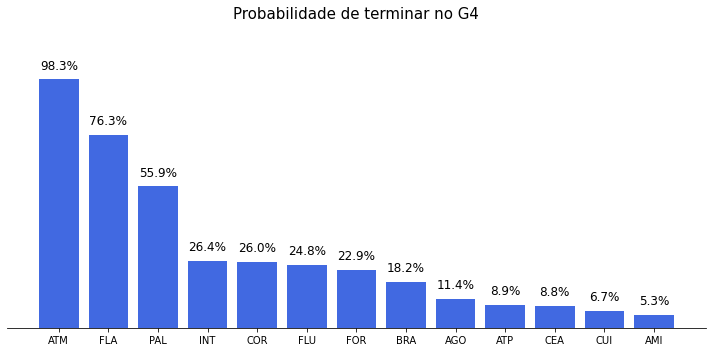

In [20]:
mask = (feq_g4 > 0.05) # Mascara para segregar quem tem mais de 5% e diminuir o ruído do gráfico


feq_g4 = feq_g4.sort_values(ascending=False) # ordena por quem tem mais probabilidade

fig, axs = plt.subplots(1, 1, figsize=(10,5))

# Plota as informações
axs.bar(feq_g4.loc[mask].index, 100*feq_g4.loc[mask], color='#4169E1')

# Configura o grafico
axs.get_yaxis().set_visible(False)
axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim(ymax=120)

eixo = axs.patches
legenda = [f'{round(100*i,1)}%' for i in feq_g4.loc[mask]]

for eixo, legenda in zip(eixo, legenda):
    height = eixo.get_height()
    axs.text(eixo.get_x() + eixo.get_width() / 2, height + 3, legenda,
            ha='center', va='bottom', fontsize=12)

axs.set_title('Probabilidade de terminar no G4', fontsize=15)

plt.tight_layout()
plt.savefig('prob de g4.png', dpi=400)
plt.show()

# COMPARANDO OS MODELOS

a etapa final da análise é comparar o que o modelo prevê em relação a modelos mais famosos, como do site Infobola e do departamento de matemática da UFMG

#                                 Corrida contra o rebaixamento

As proximas celulas preparam os DataFrames que serão juntados no gráfico de comparação

In [21]:
df_info = pd.read_excel('infobola chances de cair.xlsx')[['Clubes', 'Risco']]

df_info.Risco = 100*df_info.Risco.astype('str').apply(lambda x: x.replace('-', '0')).astype('float')
df_info.Clubes = df_info.Clubes.apply(lambda x: x.lower().replace('inter', 'internacional'))

df_info.columns = ['Clubes', 'Risco InfoBola']


df_ufmg = pd.read_excel('ufmg chance de cair.xlsx')[['Times', 'Prob(%)']]

df_ufmg.columns = ['Clubes', 'Risco UFMG']
df_ufmg.Clubes = df_ufmg.Clubes.apply(lambda x: x.lower().replace('bragantino', 'rb bragantino'))

temp = pd.merge(left=df_info, right=df_ufmg, how='left')
temp

,Clubes,Risco InfoBola,Risco UFMG
0,chapecoense,99.0,99.500
1,sport,80.0,78.700
2,grêmio,41.0,47.500
3,bahia,54.0,46.800
4,santos,42.0,43.700
5,juventude,21.0,21.100
6,américa-mg,20.0,18.200
7,são paulo,13.0,11.800
8,ceará,9.0,10.200
9,cuiabá,11.0,11.100


In [22]:
feq_rebaixamento = pd.DataFrame(feq_rebaixamento).reset_index()
feq_rebaixamento.columns = ['sigla', 'Risco Monte-Carlo']
feq_rebaixamento['Risco Monte-Carlo'] = 100*feq_rebaixamento['Risco Monte-Carlo']

df_monte = pd.merge(left=feq_rebaixamento, right=df_clubes, left_on='sigla', right_on='clubeNomeCodigo', how='inner')[['clubeShortName', 'Risco Monte-Carlo']]

df_monte.columns = ['Clubes', 'Risco Monte-Carlo']
df_monte.Clubes = df_monte.Clubes.apply(lambda x: x.lower().replace('sport recife', 'sport'))

df_monte

,Clubes,Risco Monte-Carlo
0,chapecoense,98.72
1,sport,73.85
2,são paulo,15.43
3,atlético go,8.92
4,bahia,45.09
5,grêmio,35.12
6,santos,42.66
7,ceará,12.65
8,athletico pr,10.45
9,cuiabá,12.27


In [23]:
df_rebaixamento = pd.merge(left=temp, right=df_monte, how='inner').sort_values('Risco Monte-Carlo', ascending=False)

df_rebaixamento.index = range(df_rebaixamento.shape[0])

df_rebaixamento

,Clubes,Risco InfoBola,Risco UFMG,Risco Monte-Carlo
0,chapecoense,99.0,99.5,98.72
1,sport,80.0,78.7,73.85
2,bahia,54.0,46.8,45.09
3,santos,42.0,43.7,42.66
4,grêmio,41.0,47.5,35.12
5,juventude,21.0,21.1,25.87
6,são paulo,13.0,11.8,15.43
7,ceará,9.0,10.2,12.65
8,cuiabá,11.0,11.1,12.27


# Gráfico de comparação: rebaixamento

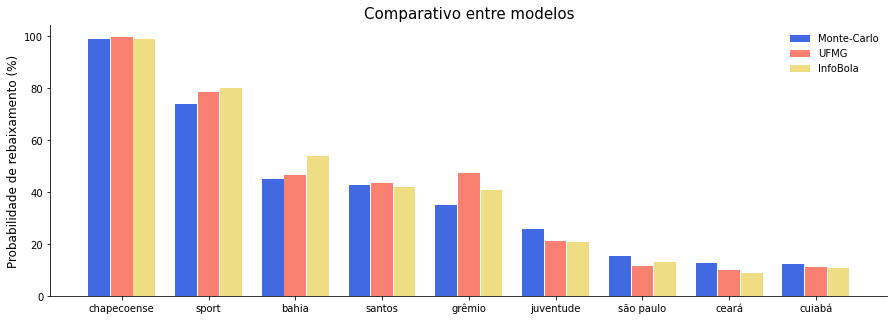

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(15,5))

x = np.arange(df_rebaixamento.shape[0])  # the label locations
width = 0.25  # the width of the bars

axs.set_xticks(x)

axs.set_xticklabels(df_rebaixamento.Clubes.values)

rects = axs.bar(x - (width +0.01), df_rebaixamento['Risco Monte-Carlo'], width, label='Monte-Carlo', color='#4169E1')
rects = axs.bar(x, df_rebaixamento['Risco UFMG'], width, label='UFMG', color='#FA8072')
rects = axs.bar(x + (width +0.01), df_rebaixamento['Risco InfoBola'], width, label='InfoBola', color='#EEDD82')

axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)

axs.set_ylabel('Probabilidade de rebaixamento (%)', fontsize=12)
axs.set_title('Comparativo entre modelos', fontsize=15)
axs.legend(frameon=False)

plt.savefig('Comparando modelos rebaixamento.png', dpi=500)

#                                        Chances de Título

In [25]:
df_info = pd.read_excel('infobola chances de titulo.xlsx')[['Clubes', 'Chances']].dropna()

df_info.Chances = 100*df_info.Chances.astype('str').apply(lambda x: x.replace('-', '0')).astype('float')
df_info.Clubes = df_info.Clubes.apply(lambda x: x.lower().replace(' ', ''))

df_info.columns = ['Clubes', 'Chances InfoBola']


df_ufmg = pd.read_excel('ufmg chances de titulo.xlsx')[['Times', 'Prob(%)']]

df_ufmg.columns = ['Clubes', 'Chances UFMG']
df_ufmg.Clubes = df_ufmg.Clubes.apply(lambda x: x.lower())

temp = pd.merge(left=df_info, right=df_ufmg, left_on='Clubes', right_on='Clubes')

temp

,Clubes,Chances InfoBola,Chances UFMG
0,atlético-mg,87.0,86.9
1,flamengo,10.0,9.0
2,palmeiras,3.0,2.7


In [26]:
df_monte = pd.DataFrame()
df_monte['Clubes'] = ['atlético-mg', 'flamengo', 'palmeiras']
df_monte['Chances Monte-Carlo'] = [gal_camp, fla_camp, pal_camp]

df_monte

,Clubes,Chances Monte-Carlo
0,atlético-mg,79.3689
1,flamengo,15.9308
2,palmeiras,4.7003


In [27]:
df_titulo = pd.merge(left=df_monte, right=temp)

df_titulo

,Clubes,Chances Monte-Carlo,Chances InfoBola,Chances UFMG
0,atlético-mg,79.3689,87.0,86.9
1,flamengo,15.9308,10.0,9.0
2,palmeiras,4.7003,3.0,2.7


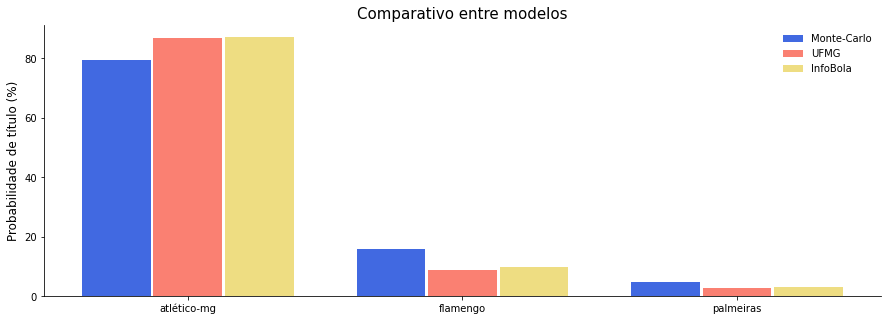

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(15,5))

x = np.arange(df_titulo.shape[0])  # the label locations
width = 0.25  # the width of the bars

axs.set_xticks(x)

axs.set_xticklabels(df_titulo.Clubes.values)

rects = axs.bar(x - (width +0.01), df_titulo['Chances Monte-Carlo'], width, label='Monte-Carlo', color='#4169E1')
rects = axs.bar(x, df_titulo['Chances UFMG'], width, label='UFMG', color='#FA8072')
rects = axs.bar(x + (width +0.01), df_titulo['Chances InfoBola'], width, label='InfoBola', color='#EEDD82')

axs.spines['right'].set_visible(False)          
axs.spines['top'].set_visible(False)

axs.set_ylabel('Probabilidade de título (%)', fontsize=12)
axs.set_title('Comparativo entre modelos', fontsize=15)
axs.legend(frameon=False)

plt.savefig('Comparando modelos título.png', dpi=500)